## PHYS-243 Spring 2019 - Brandon Evans - Homework 4
#### Dr. Mobasher, TA Abtin Shahidi <br> 5-Jun-2019
Using code and direction from Abtin's Week 7 Lab Notes:<br>
https://abtinshahidi.github.io/teaching/2019-spring-foundation-machine-learning/week7

In [1]:
#Data science greatest hits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import zscore
%matplotlib inline

## Part 1 - Classifying MNIST '9' Digit
1. Find the 9s using K-Nearest neighbours for Minkowski metric of order (1, 2, 3).
2. Find the 9s using Decision tree.
3. Find the 9s using Random Forests.

### Get the MNIST dataset

In [2]:
# Downloading the dataset
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8)
    mnist.data = mnist.data.astype(np.uint8) #Default was float64
    print("Loaded MNIST_784")
except ImportError:
    from sklearn.datasets import fetch_mldata
    print("Error getting MNIST_784, reverting to MNIST Original")
    mnist = fetch_mldata('MNIST original')
    print("Loaded MNIST Original")

Loaded MNIST_784


### Data Inspect/Clean

In [47]:
print(mnist['details']['name'])
print(mnist['url'])
print("Data Shape: {}".format(mnist['data'].shape))
print("Target Shape: {}".format(mnist['target'].shape))

mnist_784
https://www.openml.org/d/554
Data Shape: (70000, 784)
Target Shape: (70000,)


It appears like the data is a 70,000 element by 784-pixel image array
Target should corresond to the particular image's label, aligned by index between data and target

In [ ]:
print(mnist['DESCR'])

In [ ]:
print("Data:")
print(mnist["data"][0])
print("Target:")
print(mnist["target"][0])#Preview some data

In [ ]:
type(mnist["data"][0][0])

In [ ]:
#Any suspect records?
for i in range(0,len(mnist['data'])):
    if mnist['data'][i].sum() <= 0:
        print("Suspect record at index:{}".format(i))

### Explore the data...

In [48]:
def showImageByIndex(i):
    img = mnist["data"][i].reshape(28, 28)
    plt.imshow(img, cmap=mpl.cm.binary)
    
def previewImages(dataset,rows=3,columns=3,startIndex=-1):
    numImages = rows*columns #Respect subplot row/column format
    if rows<=0 or columns<=0:
        print("rows and columns must be > 0");return
    if rows>9 or columns>9:
        print("rows and columns are limited to 9 max");return
    
    if startIndex == -1: #Randomize
        selection = np.random.randint(0,len(mnist['data']),numImages)
    else:
        selection = range(startIndex,(startIndex+numImages))
    #Using subplots, like how Abtin did those
    j = 1
    for i in selection:
        img = dataset[i].reshape(28, 28)
        plt.subplot(rows,columns,j); plt.imshow(img, cmap=mpl.cm.binary)
        plt.text(0, 0, "Index:{}".format(i))
        j+=1

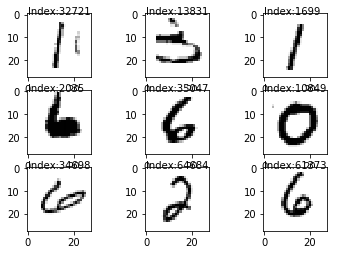

In [49]:
previewImages(mnist['data'],3,3)

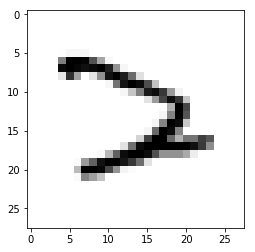

In [50]:
showImageByIndex(41668)

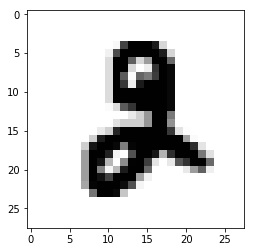

In [51]:
showImageByIndex(35410) #Ewwww.

#### Impressions so far
* No seemingly incomplete/corrupt images
* Some images are pretty poor quality
* 70,000 images, 768 pixels each, pixel values were FLOAT64 by default, but appeared to be simple uINT8 grayscale bytes so I changed accordingly
* I am intrigued at which algorithm will perform best here. Abtin's SVM performance was impressive with 5000 records!

### Part 1.1:  Find the 9s using K-Nearest neighbours for Minkowski metric of order (1, 2, 3).


In [52]:
#Let's get only the labeled '9's in the dataset
#nineX = np.zeros((0,784),dtype=np.uint8)
#nineY = np.zeros(0,dtype=np.int8)
nineX = np.copy(mnist['data'])
nineY = np.copy(mnist['target'])

for i in range(0,len(nineY)):
    nineY[i] = 1 if (nineY[i]==9) else 0 #Is a nine or not
    
#    if mnist['target'][i] == 9:
#        _x = np.zeros((1,784),dtype=np.uint8)
#        _x = np.array([mnist['data'][i]]) #Double-brackets to add dimension
#        _y = mnist['target'][i]
#        nineX = np.append(nineX, _x, axis=0)
#        nineY = np.append(nineY,_y)

In [53]:
#Split dataset
TEST_SPLIT = 0.15
train_x, test_x, train_y, test_y = train_test_split(nineX, nineY , test_size=TEST_SPLIT)

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(train_x[:5000], train_y[:5000])
accuracy = knn.score(test_x, test_y)
print(accuracy)

0.973047619047619


#### Try various neighbors

Best accuracy:0.9741904761904762 Neighbors:3


Text(0, 0.5, 'Accuracy')

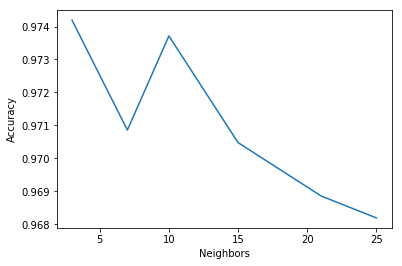

In [55]:
#Let's interate and find best accuracy

#WARNING:  Takes a while...

best_accr = 0
best_neighbor = 0

#Set some various neighbors
n = np.array([3,7,10,15,21,25])
acc = np.zeros(len(n))
for i,j in enumerate(n):
    knn = KNeighborsClassifier(n_neighbors=j)
    knn.fit(train_x[:1000], train_y[:1000])
    accuracy = knn.score(test_x, test_y)
    acc[i] = accuracy
    if accuracy > best_accr:
        best_accr = accuracy
        best_neighbor = j
print("Best accuracy:{} Neighbors:{}".format(best_accr,best_neighbor))
plt.plot(n,acc)
plt.xlabel("Neighbors")
plt.ylabel("Accuracy")

#### Try different Minkowski orders

Best accuracy:0.9438095238095238 Minkowsi Order:2


Text(0, 0.5, 'Accuracy')

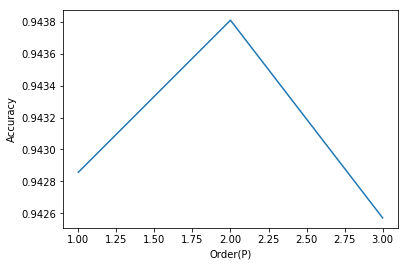

In [56]:
best_accr = 0
best_order = 0
n = np.array([1,2,3])
acc = np.zeros(len(n))
for i,j in enumerate(n):
    knn = KNeighborsClassifier(n_neighbors=10,p=j)
    knn.fit(train_x[:500], train_y[:500])
    accuracy = knn.score(test_x, test_y)
    acc[i] = accuracy
    if accuracy > best_accr:
        best_accr = accuracy
        best_order = j
print("Best accuracy:{} Minkowsi Order:{}".format(best_accr,best_order))
plt.plot(n,acc)
plt.xlabel("Order(P)")
plt.ylabel("Accuracy")

### Part 1.2:  Find the 9s using Decision Tree


In [58]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(criterion="gini",max_depth=3)
DTC.fit(train_x[:10000], train_y[:10000])
print("Accuracy: {}".format(DTC.score(test_x,test_y)))

Accuracy: 0.9259047619047619


### Part 1.3:  Find the 9s using Random Forest


In [41]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100, max_depth=3) #gini is default estimator
RFC.fit(nineX[:10000],nineY[:10000])
print("Accuracy: {}".format(RFC.score(test_x,test_y)))

Accuracy: 0.902952380952381


### Part 1.x:  Just wanted to try support vector classifier

In [57]:
from sklearn.svm import SVC
_SVC = SVC(gamma='auto')
_SVC.fit(nineX[:1000], nineY[:1000])
print("Accuracy: {}".format(_SVC.score(test_x,test_y)))

Accuracy: 0.902


### Part 1 Findings
*  KNN had good accuracy performance
*  No discernable accuracy difference between Decision Tree and Random Forest, I think because of binary classification nature?
*  Computation slowed on KNN with P=3 order


## Part 2 - All Digits
1. First forget about the labels and run the k-means algorithm to find whether there is an
underlying patterns. So, first find the k clusters (here is obviously 10 clusters). Then
look at their labels and find the accuracy. By doing this you are turning a supervised
learning into an unsupervised learning!
2. Find the digits using K-Nearest neighbours for Minkowski metric of order (1, 2, 3).
3. Find the digits using Decision tree.
4. Find the digits using Random Forests.
5. Comment on any significant difference between your results for the binary classifier
vs multi-class classifiers.

### Part 2.1 - K-Means Clustering

In [3]:
from sklearn.cluster import KMeans
x = mnist['data'][:1000]
y = mnist['target'][:1000]
km = KMeans(n_clusters=10, random_state=0)
clusters = km.fit_predict(x)

In [4]:
print("Cluster Shape:{}".format(km.cluster_centers_.shape))

Cluster Shape:(10, 784)


In [19]:
#Trick to find most popular label
#Based on Python Data Science Handbook
#https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]
metrics.accuracy_score(y, labels)

0.576

***** Abtin, I'm stuck on aligning the actual vs. cluster labels?  This is not good accuracy with method to find mode of corresponding indices between predicted and actual labels.  I tried some manual array work too, but could not figure out a path?

### Part 2.2 - KNN

Best accuracy:0.8112380952380952 Minkowsi Order:3


Text(0, 0.5, 'Accuracy')

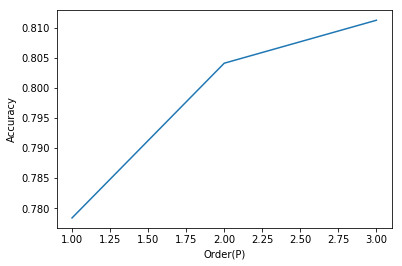

In [22]:
from sklearn.neighbors import KNeighborsClassifier
TEST_SPLIT = 0.15
train_x, test_x, train_y, test_y = train_test_split(mnist['data'], mnist['target'], test_size=TEST_SPLIT)

best_accr = 0
best_order = 0
n = np.array([1,2,3])
acc = np.zeros(len(n))
for i,j in enumerate(n):
    knn = KNeighborsClassifier(n_neighbors=10,p=j)
    knn.fit(train_x[:500], train_y[:500])
    accuracy = knn.score(test_x, test_y)
    acc[i] = accuracy
    if accuracy > best_accr:
        best_accr = accuracy
        best_order = j
print("Best accuracy:{} Minkowsi Order:{}".format(best_accr,best_order))
plt.plot(n,acc)
plt.xlabel("Order(P)")
plt.ylabel("Accuracy")

### Part 2.3 - Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
TEST_SPLIT = 0.15
train_x, test_x, train_y, test_y = train_test_split(mnist['data'], mnist['target'], test_size=TEST_SPLIT)

DTC = DecisionTreeClassifier(criterion="gini",max_depth=5)
DTC.fit(train_x[:10000], train_y[:10000])
print("Accuracy: {}".format(DTC.score(test_x,test_y)))

Accuracy: 0.9481904761904761


### Part 2.4 - Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
TEST_SPLIT = 0.15
train_x, test_x, train_y, test_y = train_test_split(mnist['data'], mnist['target'], test_size=TEST_SPLIT)

RFC = RandomForestClassifier(n_estimators=10, max_depth=10) #gini is default estimator
RFC.fit(train_x[:10000],train_y[:10000])
print("Accuracy: {}".format(RFC.score(test_x,test_y)))

Accuracy: 0.9034285714285715


### Conclusion
* Most classifiers performed well.
* With the SKLearn libraries for decision tree and random forest, how do we best determine target depth or split criteria?
* Was expecting better accuracy from random forest, but surprisingly, decision tree performed similar, perhaps MNIST dataset is not advanced enough to challenge a decision tree?